In [1]:
from rdkit import Chem
import BioSimSpace as BSS
from rdkit.Chem import rdFMCS, AllChem
import math

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


This notebook extracts the ligands from protein-ligand simulations snapshots. The two simulated structures are: 
1. GSK559 using PDB: 6RNA (DFG-in)
2. GSK583 using PDB: 5J7B (DFG-inter)

The problem this notebook solves is that the topology of the ligand in the PDB is lost, so the idea is to use the ligand SDF from PDB and do a constrained embed of its positions (including hydrogen atoms). 

- MD Snapshots are labelled: `[PDB]_pl_complex_no_water.pdb`
- Ligand / protein PDBs are separated by copying and pasting into two separate files: `[PDB]_ligand/protein_no_water.pdb`
- Ligand SDFs from PDB are labelled: `[PDB]_reference_ligand.sdf`
- The final ligand is labelled `[PDB]_ligand.sdf`



Let's have a look using the nice NGLViewer function in BSS

In [2]:
pdb = '5j7b'

In [3]:
lig = BSS.IO.readMolecules(f'../structures/{pdb}_ligand_no_water.pdb')[0]
BSS.Notebook.View(lig).system()

ThemeManager()

NGLWidget(gui_style='ngl')

Looks good, now read in using RDKit

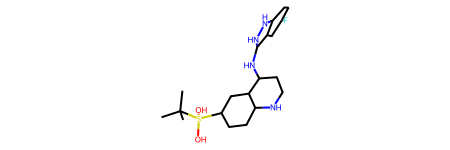

In [4]:
mol = Chem.MolFromPDBFile(f'../structures/{pdb}_ligand_no_water.pdb')
mol

Read in the ligand from the PDB:  

In [5]:
ref = Chem.SDMolSupplier(f'../structures/{pdb}_reference_ligand.sdf')[0]
ref = Chem.AddHs(ref)


Get the core structure (i.e., heavy atoms) and the mapping

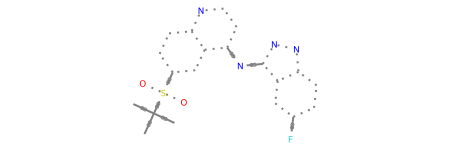

In [6]:
params = rdFMCS.MCSParameters()
params.AtomTyper = rdFMCS.AtomCompare.CompareAny
params.BondTyper =rdFMCS.BondCompare.CompareAny
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

res = rdFMCS.FindMCS([mol, ref], params)
core = Chem.MolFromSmarts(res.smartsString)

core

In [7]:
atom_map =  {i:j for i, j in enumerate(ref.GetSubstructMatch(core))}

Create the coordinate map: 

In [8]:
mol_match = mol.GetSubstructMatch(core)
ref_match = ref.GetSubstructMatch(core)
cmap = {ref_match[i]: mol.GetConformer().GetAtomPosition(mol_match[i]) for i in range(len(mol_match))}
cmap

{14: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc759c40>,
 16: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc759fc0>,
 11: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc759ec0>,
 10: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a040>,
 12: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a0c0>,
 13: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a140>,
 15: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a1c0>,
 17: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a240>,
 18: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a2c0>,
 0: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a340>,
 19: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a3c0>,
 27: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a440>,
 9: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a4c0>,
 3: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a540>,
 20: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a5c0>,
 2: <rdkit.Geometry.rdGeometry.Point3D at 0x782cdc75a640>,
 1: <rdkit.Geometry.rdGeometry.Point3D at 0x

In [9]:
AllChem.EmbedMolecule(ref, coordMap=cmap, useRandomCoords=True)
AllChem.AlignMol(ref,mol,atomMap = list(zip(ref_match,mol_match)))

0.0

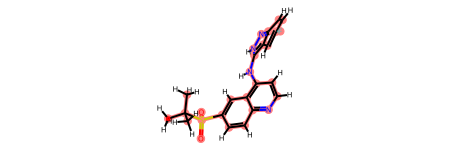

In [10]:
ref

In [11]:
Chem.SDWriter(f'../structures/{pdb}_ligand.sdf').write(ref)

Compare the structures. 

In [13]:
lig = BSS.IO.readMolecules(f'../structures/{pdb}_ligand_no_water.pdb')[0]
new_lig = BSS.IO.readMolecules(f'../structures/{pdb}_ligand.sdf')[0]
compare = lig + new_lig
BSS.Notebook.View(compare).system()

NGLWidget(gui_style='ngl')